In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist
from itertools import combinations

In [2]:
# Load dan standarisasi data
df = pd.read_csv('clusteringweek06.csv')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

In [3]:
# Fungsi menghitung Dunn Index
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    inter_cluster_distances = []
    intra_cluster_distances = []

    for (i, j) in combinations(unique_clusters, 2):
        cluster_i = X[labels == i]
        cluster_j = X[labels == j]
        distances = cdist(cluster_i, cluster_j, 'euclidean')
        inter_cluster_distances.append(np.min(distances))

    for k in unique_clusters:
        cluster_k = X[labels == k]
        if len(cluster_k) > 1:
            intra = np.max(cdist(cluster_k, cluster_k, 'euclidean'))
        else:
            intra = 0
        intra_cluster_distances.append(intra)

    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)
# Fungsi menghitung Dunn Index
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    inter_cluster_distances = []
    intra_cluster_distances = []

    for (i, j) in combinations(unique_clusters, 2):
        cluster_i = X[labels == i]
        cluster_j = X[labels == j]
        distances = cdist(cluster_i, cluster_j, 'euclidean')
        inter_cluster_distances.append(np.min(distances))

    for k in unique_clusters:
        cluster_k = X[labels == k]
        if len(cluster_k) > 1:
            intra = np.max(cdist(cluster_k, cluster_k, 'euclidean'))
        else:
            intra = 0
        intra_cluster_distances.append(intra)

    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)


In [4]:
# Cari k optimal (Elbow + Silhouette)
k_range = range(2, 11)
inertias = []
silhouettes = []
calinski_scores = []
davies_scores = []
dunn_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))
    calinski_scores.append(calinski_harabasz_score(X_scaled, labels))
    davies_scores.append(davies_bouldin_score(X_scaled, labels))
    dunn_scores.append(dunn_index(X_scaled, labels))

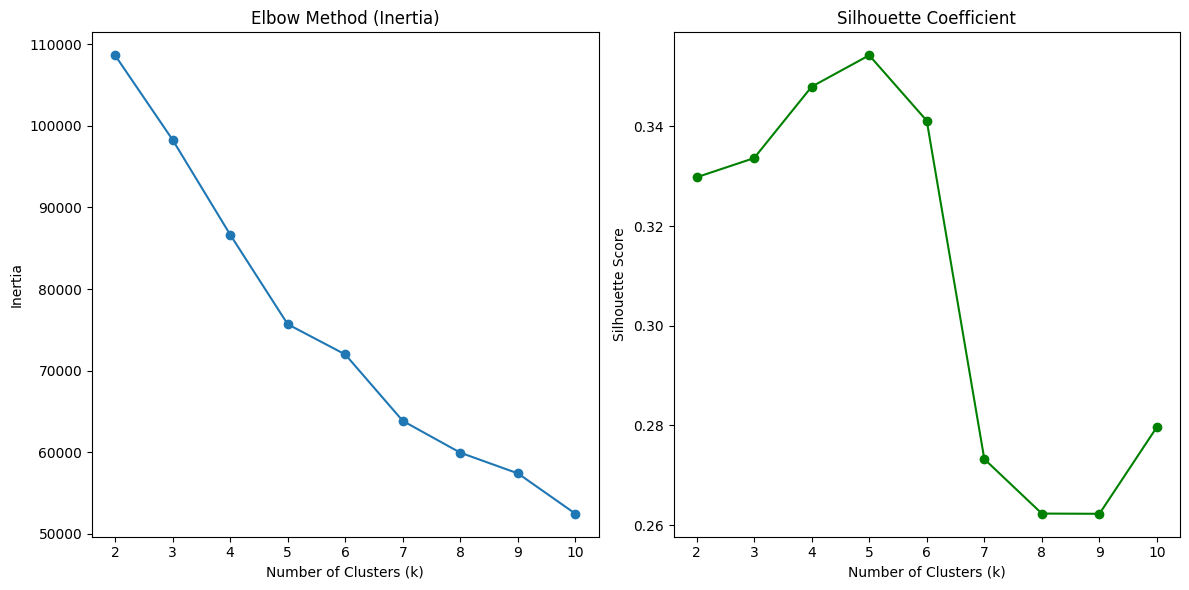

In [5]:
# Plot Elbow dan Silhouette
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouettes, marker='o', color='green')
plt.title('Silhouette Coefficient')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


In [6]:
# Tentukan k terbaik
best_k = k_range[np.argmax(silhouettes)]

In [7]:
# Fit model final
kmeans_final = KMeans(n_clusters=best_k, random_state=42).fit(X_scaled)
agglo_final = AgglomerativeClustering(n_clusters=best_k).fit(X_scaled)

In [8]:
# Evaluasi model
def evaluate_clustering(X, labels, model_name):
    return {
        'Model': model_name,
        'Silhouette': silhouette_score(X, labels),
        'Calinski-Harabasz': calinski_harabasz_score(X, labels),
        'Davies-Bouldin': davies_bouldin_score(X, labels),
        'Dunn': dunn_index(X, labels)
    }

evaluation_results = pd.DataFrame([
    evaluate_clustering(X_scaled, kmeans_final.labels_, "KMeans"),
    evaluate_clustering(X_scaled, agglo_final.labels_, "Agglomerative")
])

print("\n=== Hasil Evaluasi ===")
print(evaluation_results)


=== Hasil Evaluasi ===
           Model  Silhouette  Calinski-Harabasz  Davies-Bouldin      Dunn
0         KMeans    0.354285        1961.893190        1.347381  0.018140
1  Agglomerative    0.348511        1874.102737        1.376939  0.056562


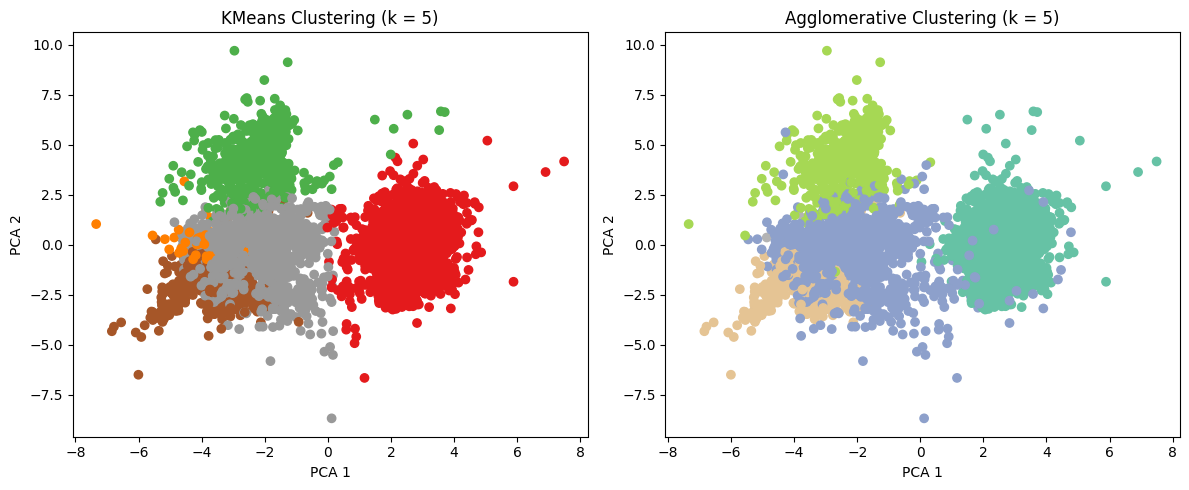

In [9]:
# Visualisasi 2D dengan PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_final.labels_, cmap='Set1')
plt.title("KMeans Clustering (k = {})".format(best_k))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agglo_final.labels_, cmap='Set2')
plt.title("Agglomerative Clustering (k = {})".format(best_k))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.tight_layout()
plt.show()

## Kesimpulan Evaluasi Clustering

Dari hasil evaluasi dua metode clustering terhadap dataset `clusteringweek06.csv`, diperoleh hasil sebagai berikut:

| Model            | Silhouette | Calinski-Harabasz | Davies-Bouldin | Dunn Index |
|------------------|------------|-------------------|----------------|------------|
| **KMeans**        | 0.3543     | 1961.89           | 1.3474         | 0.0181     |
| **Agglomerative** | 0.3485     | 1874.10           | 1.3769         | 0.0566     |

### 🔍 Analisis Metrik:
- **Silhouette Score**: Lebih tinggi pada **KMeans**, menunjukkan bahwa KMeans memiliki kohesi (kekompakan) dan separasi antar klaster yang sedikit lebih baik.
- **Calinski-Harabasz Index**: Jauh lebih tinggi pada **KMeans**, menandakan pemisahan antar klaster yang lebih jelas.
- **Davies-Bouldin Index**: Lebih rendah pada **KMeans**, yang artinya hasil clustering-nya lebih baik (semakin rendah semakin bagus).
- **Dunn Index**: Lebih tinggi pada **Agglomerative**, menunjukkan bahwa ada separasi antar klaster yang lebih baik dalam model ini (namun skor absolutnya masih cukup rendah).

### ✅ Kesimpulan:
Secara keseluruhan, meskipun **Agglomerative Clustering** unggul di **Dunn Index**, model **KMeans** menunjukkan performa yang **lebih stabil dan unggul di tiga metrik utama lainnya**: *Silhouette*, *Calinski-Harabasz*, dan *Davies-Bouldin*.

🎯 Oleh karena itu, **KMeans** tetap merupakan model clustering terbaik untuk dataset ini, dengan separasi dan kohesi antar klaster yang relatif lebih baik dibandingkan Agglomerative Clustering.


## 📐 Penjelasan Matematis Metrik Evaluasi Clustering

### 1. **Silhouette Coefficient**
Silhouette coefficient mengukur seberapa mirip sebuah titik dengan klusternya sendiri dibandingkan dengan kluster lain.

$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
$$

**Keterangan:**
- $a(i)$ = Rata-rata jarak dari titik $i$ ke semua titik lain dalam klusternya sendiri
- $b(i)$ = Rata-rata jarak dari titik $i$ ke titik-titik di kluster terdekat lainnya
- Nilai $s(i)$ berada di antara -1 dan 1:
  - $s(i) \approx 1$: Titik berada di kluster yang tepat
  - $s(i) \approx 0$: Titik di antara dua kluster
  - $s(i) \approx -1$: Titik salah tempat (mis-clustered)

---

### 2. **Calinski-Harabasz Index (Variance Ratio Criterion)**
Metrik ini membandingkan sebaran antar kluster dan dalam kluster.

$$
CH = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \cdot \frac{n - k}{k - 1}
$$

**Keterangan:**
- $B_k$ = Matriks dispersi antar kluster
- $W_k$ = Matriks dispersi dalam kluster
- $n$ = Jumlah total data
- $k$ = Jumlah kluster
- Semakin besar nilai $CH$, semakin baik pemisahan kluster

---

### 3. **Davies-Bouldin Index**
Mengukur rata-rata kemiripan antar kluster (rasio antara jarak dalam kluster dan antar kluster).

$$
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d_{ij}} \right)
$$

**Keterangan:**
- $\sigma_i$ = Rata-rata jarak dari titik-titik dalam kluster $i$ ke centroid-nya
- $d_{ij}$ = Jarak antara centroid kluster $i$ dan $j$
- Nilai yang lebih kecil menunjukkan kluster yang lebih baik (lebih kompak dan saling terpisah)

---

### 4. **Dunn Index**
Mengukur rasio antara jarak minimum antar kluster dengan jarak maksimum dalam kluster.

$$
D = \frac{\min_{1 \leq i < j \leq k} d(c_i, c_j)}{\max_{1 \leq l \leq k} \delta(C_l)}
$$

**Keterangan:**
- $d(c_i, c_j)$ = Jarak minimum antara dua kluster berbeda
- $\delta(C_l)$ = Diameter (jarak maksimum antar titik) dalam kluster $l$
- Semakin tinggi nilai Dunn Index, semakin baik pemisahan dan kekompakan kluster

---

### 📌 Kesimpulan:
| Metrik              | Interpretasi                     |
|---------------------|----------------------------------|
| **Silhouette**       | Semakin tinggi, semakin baik     |
| **Calinski-Harabasz**| Semakin tinggi, semakin baik     |
| **Davies-Bouldin**   | Semakin rendah, semakin baik     |
| **Dunn Index**       | Semakin tinggi, semakin baik     |
